# **STORYTELLING**

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import zipfile

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import r2_score ,mean_absolute_error, mean_squared_error,  max_error, explained_variance_score
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

## **Data Collection and Cleaning**

For this task we performed data scraping on the *wine.com* website. We scraped around 420k revies containing different categorical and numerical attributes for the wine, from which the text reviews of sommeliers and winemaker notes from the wine producer are the ones that stick out the most.

The next couple of cells countain the data already cleaned in our EDA and Cleaning notebook.

In [3]:
# Opening zipfile and reading it to a dataframe
with zipfile.ZipFile('wine_reviews_clean.zip', 'r') as zipf:
    zipf.extractall('')

df = pd.read_csv('wine_reviews_clean.csv')

os.remove('wine_reviews_clean.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421017 entries, 0 to 421016
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Name                421017 non-null  object 
 1   Variety             421017 non-null  object 
 2   Country             421017 non-null  object 
 3   Region              386109 non-null  object 
 4   Zone                253609 non-null  object 
 5   Attr_1              417986 non-null  object 
 6   Attr_2              76720 non-null   object 
 7   Winemaker_notes     95234 non-null   object 
 8   Review              93840 non-null   object 
 9   Alcohol_percentage  420952 non-null  float64
 10  Alcohol_vol         420952 non-null  float64
 11  Avg_rating          45970 non-null   float64
 12  N_ratings           45970 non-null   float64
 13  Price_Feature       419607 non-null  float64
 14  Year                418078 non-null  float64
dtypes: float64(6), object(9)
memory us

In [4]:
# Check for outliers
def get_outliers(data, threshold=3):
    z_scores = np.abs(stats.zscore(data, nan_policy='omit'))
    outliers = np.where(z_scores > threshold, np.nan, 0)
    return outliers

outliers = df.select_dtypes('float64').apply(get_outliers, axis=0)

outliers_df = df.join(outliers, rsuffix='_IsOutlier')

outliers_df.iloc[:, -6:].notna().sum()

Alcohol_percentage_IsOutlier    420998
Alcohol_vol_IsOutlier           415141
Avg_rating_IsOutlier            420717
N_ratings_IsOutlier             420362
Price_Feature_IsOutlier         412648
Year_IsOutlier                  418243
dtype: int64

In [9]:
# Eliminate this outliers
clean_df = outliers_df.dropna(subset=outliers_df.columns.tolist()[-6:])
clean_df = clean_df.drop(outliers_df.columns.tolist()[-6:], axis=1)

clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 405906 entries, 0 to 421016
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Name                405906 non-null  object 
 1   Variety             405906 non-null  object 
 2   Country             405906 non-null  object 
 3   Region              371395 non-null  object 
 4   Zone                241475 non-null  object 
 5   Attr_1              403100 non-null  object 
 6   Attr_2              68063 non-null   object 
 7   Winemaker_notes     89805 non-null   object 
 8   Review              84430 non-null   object 
 9   Alcohol_percentage  405841 non-null  float64
 10  Alcohol_vol         405841 non-null  float64
 11  Avg_rating          44313 non-null   float64
 12  N_ratings           44313 non-null   float64
 13  Price_Feature       405168 non-null  float64
 14  Year                403193 non-null  float64
dtypes: float64(6), object(9)
memory us

In [6]:
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
import re

# Function to delete stopwords from the text
stop_words = set(stopwords.words('english'))
def strip_stopwords_lemmatize(text, lemmatize=True):
    try:
        # Convert text into lowercase
        text = text.lower()

        # Remove non alphanumerical characters and split the text into words
        words = re.findall(r'\b\w+\b', text)

        # Remove stopwords
        clean_words = [word for word in words if word not in stop_words]

        if lemmatize:
            # Lemmatize using WordNetLemmatizer
            WNLemma = WordNetLemmatizer()
            lemmatized_words = [WNLemma.lemmatize(word) for word in clean_words]
            lemmatized_text = ' '.join(lemmatized_words)
            return lemmatized_text
        else:
            # Cleaned text
            cleaned_text = ' '.join(clean_words)
            return cleaned_text
    except:
        # Case when there is no text to analyze
        return np.nan

In [10]:
# Cleaning the text of winemaker notes and review
print(clean_df.iloc[4]['Winemaker_notes'])

clean_df['Winemaker_notes'] = clean_df['Winemaker_notes'].apply(strip_stopwords_lemmatize)
clean_df['Review'] = clean_df['Review'].apply(strip_stopwords_lemmatize)

print(clean_df.iloc[4]['Winemaker_notes'])

Made with organically farmed fruit, the La Morra Barolo offers an honest and classic interpretation with wild berries, sour cherry and forest bramble. Hints of licorice and chocolate with plums and berries. Floral. Medium to full body, soft and velvety tannins and a spicy finish. Pair with roasted lamb, veal shank, braised duck, medium aged cheeses.
made organically farmed fruit la morra barolo offer honest classic interpretation wild berry sour cherry forest bramble hint licorice chocolate plum berry floral medium full body soft velvety tannin spicy finish pair roasted lamb veal shank braised duck medium aged cheese


## **Model Selection**

For this task we decided to take two different approaches. The first one is to get to know if there is a possibility to predict the comsumers perception of the wine based on the Avg_rating. The other approach is if there is a way to predict the price of a wine based on its characteristics and subjective reviews.

This way we pretend to have a market understanding of wine so that, in future implementations, the models can be harness to support decision making for wine executives.

### **Unsupervised Learning**

One of the main priorities to undergo classification is to create a class based on the average rating of the wines. In order to perform this data-based and not guide ourselves only with intuition, we performed a clustering algorithm based on different features.

We found out that the features that allowed for a better separation of the average rating are:
- Winemaker_notes
- Review
- Avg_rating (of course)
- Price_Feature
- Year

In [12]:
from sklearn.cluster import BisectingKMeans

# Fe columns
fe_cols = ['Winemaker_notes', 'Review', 'Avg_rating', 'Price_Feature', 'Year']

# Dataset for experimentation
fe = clean_df.dropna(subset=fe_cols)

# Creating ColumnTransformer to engineer the features into usable ones for a clustering model
preprocessor = ColumnTransformer([
    ('Winemaker_notes', TfidfVectorizer(ngram_range=(1,2)), 'Winemaker_notes'),
    ('Review', TfidfVectorizer(ngram_range=(1,2)), 'Review'),
    ('Avg_rating', MinMaxScaler(), ['Avg_rating']),
    ('Price_Feature', MinMaxScaler(), ['Price_Feature']),
    ('Year', MinMaxScaler(), ['Year'])
],
verbose=True,
remainder='passthrough')

# Creating Pipeline
fe_cluster = Pipeline([
    ('preprocessor', preprocessor),
    ('cluster', BisectingKMeans(n_clusters=3))
])

# Predicting the cluster for the whole dataset
fe['cluster'] = fe_cluster.fit_predict(fe[fe_cols])

# Describe the dataframe based on the created clusters
fe.groupby('cluster').describe()[['Avg_rating', 'Price_Feature']]

[ColumnTransformer]  (1 of 5) Processing Winemaker_notes, total=   2.2s
[ColumnTransformer] ........ (2 of 5) Processing Review, total=   2.3s
[ColumnTransformer] .... (3 of 5) Processing Avg_rating, total=   0.0s
[ColumnTransformer] . (4 of 5) Processing Price_Feature, total=   0.0s
[ColumnTransformer] .......... (5 of 5) Processing Year, total=   0.0s


Avg_rating                                              Price_Feature  \
             count      mean       std  min  25%  50%  75%  max         count   
cluster                                                                         
0           6671.0  4.484200  0.248780  3.6  4.3  4.4  4.6  5.0        6671.0   
1           3280.0  3.547470  0.257394  2.8  3.4  3.6  3.7  4.1        3280.0   
2           8526.0  3.953554  0.173252  3.4  3.8  4.0  4.1  4.3        8526.0   

                                                                  
              mean        std   min    25%    50%    75%     max  
cluster                                                           
0        68.410824  52.022855  7.99  32.99  51.99  89.99  284.99  
1        25.588808  15.611228  7.97  15.99  20.99  29.99  169.00  
2        25.499945  11.734084  7.97  17.99  22.99  29.99  159.00

With the ***BisectingKMeans*** approach we managed to identify three classes that can be viable for a classification problem, each one determined by each cluster found int he algorithm.
- Cluster 0: Classical wines with the highest rating.
- Cluster 1: Good wines with above average rating.
- Cluster 2: Acceptable wines with average rating.

This way we now have a strategy based on the data itself to partition the data in order to generate viable classes to continue with classification.

In [13]:
# Creating Pipeline for 2 clusters
fe_cluster = Pipeline([
    ('preprocessor', preprocessor),
    ('cluster', BisectingKMeans(n_clusters=2))
])

# Predicting the cluster for the whole dataset
fe['cluster'] = fe_cluster.fit_predict(fe[fe_cols])

# Describe the dataframe based on the created clusters
fe.groupby('cluster').describe()[['Avg_rating', 'Price_Feature']]

[ColumnTransformer]  (1 of 5) Processing Winemaker_notes, total=   2.1s
[ColumnTransformer] ........ (2 of 5) Processing Review, total=   2.1s
[ColumnTransformer] .... (3 of 5) Processing Avg_rating, total=   0.0s
[ColumnTransformer] . (4 of 5) Processing Price_Feature, total=   0.0s
[ColumnTransformer] .......... (5 of 5) Processing Year, total=   0.0s


Avg_rating                                              Price_Feature  \
             count      mean       std  min  25%  50%  75%  max         count   
cluster                                                                         
0          12121.0  3.851101  0.274765  2.8  3.7  3.9  4.0  4.4       12121.0   
1           6356.0  4.496318  0.247923  3.6  4.3  4.5  4.7  5.0        6356.0   

                                                                  
              mean        std   min    25%    50%    75%     max  
cluster                                                           
0        25.709508  13.046607  7.97  16.99  22.99  29.99  169.00  
1        70.183682  52.556879  7.99  33.99  53.99  89.99  284.99

We now have two different target variables that seem plausible for classification. One that divides wine into three categories (Acceptable, Good, Classical) and another that divides them into two (Good, Classical).

With this engineered categories we can tackle the task of classification.

In [14]:
# Creating a class to predict based on the unsupervised method
clean_df['Rating_3Class'] = np.where(pd.isna(clean_df['Avg_rating']), pd.NA,
                               np.where(clean_df['Avg_rating'] < 3.8, 'Acceptable',
                                        np.where(clean_df['Avg_rating'] < 4.4, 'Good', 'Classical')))

clean_df['Rating_2Class'] = np.where(pd.isna(clean_df['Avg_rating']), pd.NA,
                                     np.where(clean_df['Avg_rating'] < 4.5, 'Good', 'Classical'))

print(clean_df['Rating_3Class'].value_counts())
print()
print(clean_df['Rating_2Class'].value_counts())

Good          24047
Classical     10454
Acceptable     9812
Name: Rating_3Class, dtype: int64

Good         36703
Classical     7610
Name: Rating_2Class, dtype: int64


### **Classification**

For this task we will use the previously engineered features from the unsupervised learning section. We experimented with different models such as Naive Bayes, SVM, Random Forests and Logistic Regression. 

As we can see in the previous section, both class variables, either 3 or 2 class, are fairly imbalanced, so we have to use an oversamplin technique to achive better results and avoid having skewed data. We chose to go with the random over sampler approach over the SMOTE technique, this due to its short time to finish the over sampling.

After performing the different experiments we determined that Naive Bayes, with its ComplementNB model, performs the best in terms of training time and overall accuracy. Other models performed slightly better or worse at the cost of a significant increase in training time.

The next cells depict the classification approach for all variables with either 3 or 2 class classification.

              precision    recall  f1-score   support

  Acceptable       0.30      0.46      0.36       657
   Classical       0.42      0.65      0.51       862
        Good       0.67      0.40      0.50      1988

    accuracy                           0.47      3507
   macro avg       0.47      0.50      0.46      3507
weighted avg       0.54      0.47      0.48      3507



<Figure size 800x500 with 0 Axes>

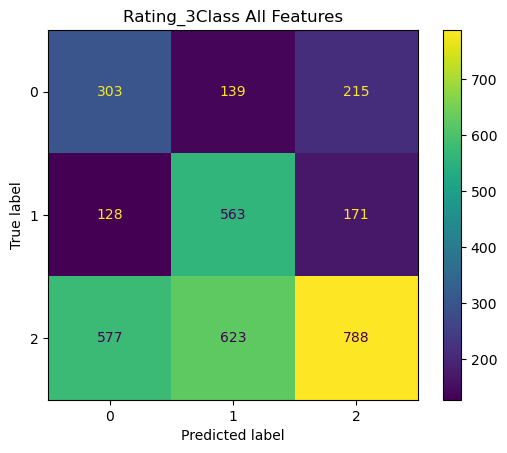

In [15]:
from imblearn.pipeline import Pipeline as ImbalancedPipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Select the variables for the experiment at hand
clf_var = ['Variety', 'Country', 'Region', 'Attr_1', 'Alcohol_percentage', 'Alcohol_vol', 'Price_Feature', 'Year',
            'Winemaker_notes', 'Review', 'Rating_3Class']

# Dataframe with the corresponding variables and dropping null values
clf_df = clean_df.dropna(subset=clf_var)

# Splitting classifiers and class
X = clf_df[clf_var].iloc[:, :-1]
y = clf_df[clf_var].iloc[:, -1]

# Splitting between test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=0)

# Creating preprocessor with ColumnTransformer
clf_preprocessor = ColumnTransformer([
    ('Variety', OneHotEncoder(handle_unknown='ignore'), ['Variety']),
    ('Country', OneHotEncoder(handle_unknown='ignore'), ['Country']),
    ('Region', OneHotEncoder(handle_unknown='ignore'), ['Region']),
    ('Attr_1', OneHotEncoder(handle_unknown='ignore'), ['Attr_1']),
    ('Alcohol_percentage', MinMaxScaler(), ['Alcohol_percentage']),
    ('Alcohol_vol', MinMaxScaler(), ['Alcohol_vol']),
    ('Price_Feature', MinMaxScaler(), ['Price_Feature']),
    ('Year', MinMaxScaler(), ['Year']),
    ('Winemaker_notes', TfidfVectorizer(ngram_range=(1,2)), 'Winemaker_notes'),
    ('Review', TfidfVectorizer(ngram_range=(1,2)), 'Review')
],
remainder='passthrough')

# Creating an ImbalancedPipeline with preprocessor, SMOTE, and Classifier
clf_pipeline = ImbalancedPipeline([
    ('preprocessing', clf_preprocessor),
    ('oversampling', RandomOverSampler(sampling_strategy='not majority', random_state=0)),
    ('classifier', ComplementNB())
])

# Fitting the model and making predictions
clf_pipeline.fit(X_train, y_train)
y_pred = clf_pipeline.predict(X_test)

# Create classification report
print(classification_report(y_test, y_pred))

# Display the confusion matrix
plt.figure(figsize=(8,5))
cm = confusion_matrix(y_test, y_pred)
matrix_plot = ConfusionMatrixDisplay(confusion_matrix=cm)
matrix_plot.plot();
plt.title('Rating_3Class All Features');

In [16]:
# Groupby Rating class
df = clean_df.dropna(subset=clf_var[:-1])
df['Rating_3Class'] = clf_pipeline.predict(df[clf_var[:-1]])
df.groupby('Rating_3Class').describe(include='all')[['Variety', 'Country', 'Attr_1', 'Alcohol_percentage', 'Avg_rating', 'Price_Feature']]

Variety                                                         \
                count unique         top  freq mean  std  min  25%  50%  75%   
Rating_3Class                                                                  
Acceptable      10236    110  Chardonnay  1233  NaN  NaN  NaN  NaN  NaN  NaN   
Classical       18337     84  Pinot Noir  3065  NaN  NaN  NaN  NaN  NaN  NaN   
Good            12549    100  Pinot Noir  1506  NaN  NaN  NaN  NaN  NaN  NaN   

                   Country                                                  \
               max   count unique            top  freq mean  std  min  25%   
Rating_3Class                                                                
Acceptable     NaN   10236     14  United States  2971  NaN  NaN  NaN  NaN   
Classical      NaN   18337     13         France  6803  NaN  NaN  NaN  NaN   
Good           NaN   12549     13  United States  6287  NaN  NaN  NaN  NaN   

                             Attr_1                                           \
               50%  75%  max  count unique         top   freq mean  std  min   
Rating_3Class                                                                  
Acceptable     NaN  NaN  NaN  10236      5  White Wine   5193  NaN  NaN  NaN   
Classical      NaN  NaN  NaN  18337      8    Red Wine  14276  NaN  NaN  NaN   
Good           NaN  NaN  NaN  12549      5    Red Wine   9062  NaN  NaN  NaN   

                                  Alcohol_percentage                  \
               25%  50%  75%  max              count unique top freq   
Rating_3Class                                                          
Acceptable     NaN  NaN  NaN  NaN            10236.0    NaN NaN  NaN   
Classical      NaN  NaN  NaN  NaN            18337.0    NaN NaN  NaN   
Good           NaN  NaN  NaN  NaN            12549.0    NaN NaN  NaN   

                                                                Avg_rating  \
                    mean       std  min   25%   50%   75%   max      count   
Rating_3Class                                                                
Acceptable     10.274554  5.748035  0.0   9.5  13.0  14.0  20.0     4270.0   
Classical       9.299601  6.655823  0.0   0.0  13.5  14.5  21.0     5659.0   
Good           11.073797  5.651536  0.0  12.5  13.6  14.5  24.9     7603.0   

                                                                            \
              unique top freq      mean       std  min  25%  50%  75%  max   
Rating_3Class                                                                
Acceptable       NaN NaN  NaN  3.703419  0.355807  2.8  3.5  3.7  3.9  5.0   
Classical        NaN NaN  NaN  4.427885  0.349509  2.8  4.2  4.5  4.7  5.0   
Good             NaN NaN  NaN  4.026437  0.203846  2.9  3.9  4.0  4.2  5.0   

              Price_Feature                                              \
                      count unique top freq       mean        std   min   
Rating_3Class                                                             
Acceptable          10236.0    NaN NaN  NaN  32.663783  24.352268  5.99   
Classical           18337.0    NaN NaN  NaN  86.704000  58.801861  7.97   
Good                12549.0    NaN NaN  NaN  35.291669  23.748714  7.99   

                                             
                 25%    50%     75%     max  
Rating_3Class                                
Acceptable     17.99  23.99   38.99  279.99  
Classical      42.99  69.99  119.97  285.97  
Good           19.99  27.99   42.99  279.99

After performing the experimentation and predicting the available data with the model we have achieved fairly good accuracy, but the data is highly imbalanced still, so, most reviews get predicted to be part of the dominant class. 

Besides, we can extract some valuable conclusions from this task:
- **Classical wines tend to be from France, while Acceptable and Good wines from the US.** This seems fairly accurate due to most wines in the dataset being from the US and the wines with the highest price and avg_rating come from France.
- **Acceptable wines tend to be White wines, while Good and Classical wines are Red wines.**
- **Lower alcohol percentage wines tend to be Classical wines, while the other ones have higher percentages**.Looking at the quartiles we can see that there are wines with no alcohol and up to 20% alcohol in all classes. This trend seems to be only for wines that fall under the "typicall" wine alcohol percentage.
- **Avg_rating was classified correctly in average**, in each class the wines tend to range from 2.8 onwards, but the 3rd quartile allows for better separation of the wines according to the aforemention class.
- **Price is much higher for Classical wines**, where for both Good and Acceptable wines the prices are fairly similar.

              precision    recall  f1-score   support

   Classical       0.35      0.65      0.45       632
        Good       0.90      0.73      0.81      2875

    accuracy                           0.71      3507
   macro avg       0.63      0.69      0.63      3507
weighted avg       0.80      0.71      0.74      3507



<Figure size 800x500 with 0 Axes>

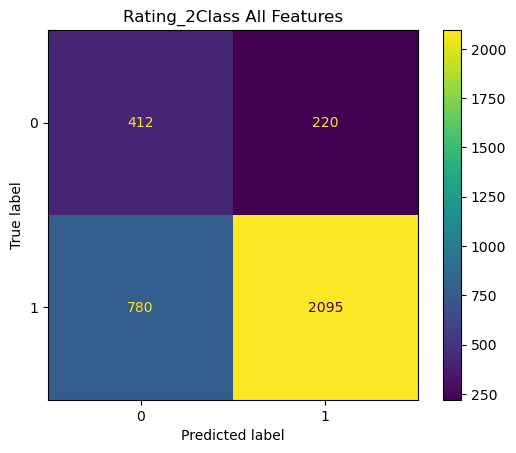

In [17]:
# Select the variables for the experiment at hand
clf2_var = ['Variety', 'Country', 'Region', 'Attr_1', 'Alcohol_percentage', 'Alcohol_vol', 'Price_Feature', 'Year',
            'Winemaker_notes', 'Review', 'Rating_2Class']

# Dataframe with the corresponding variables and dropping null values
clf2_df = clean_df.dropna(subset=clf2_var)

# Splitting classifiers and class
X = clf2_df[clf2_var].iloc[:, :-1]
y = clf2_df[clf2_var].iloc[:, -1]

# Splitting between test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=0)

# Creating preprocessor with ColumnTransformer
clf2_preprocessor = ColumnTransformer([
    ('Variety', OneHotEncoder(handle_unknown='ignore'), ['Variety']),
    ('Country', OneHotEncoder(handle_unknown='ignore'), ['Country']),
    ('Region', OneHotEncoder(handle_unknown='ignore'), ['Region']),
    ('Attr_1', OneHotEncoder(handle_unknown='ignore'), ['Attr_1']),
    ('Alcohol_percentage', MinMaxScaler(), ['Alcohol_percentage']),
    ('Alcohol_vol', MinMaxScaler(), ['Alcohol_vol']),
    ('Price_Feature', MinMaxScaler(), ['Price_Feature']),
    ('Year', MinMaxScaler(), ['Year']),
    ('Winemaker_notes', TfidfVectorizer(ngram_range=(1,2)), 'Winemaker_notes'),
    ('Review', TfidfVectorizer(ngram_range=(1,2)), 'Review')
],
remainder='passthrough')

# Creating an ImbalancedPipeline with preprocessor, SMOTE, and Classifier
clf2_pipeline = ImbalancedPipeline([
    ('preprocessing', clf2_preprocessor),
    ('oversampling', RandomOverSampler(sampling_strategy='not majority', random_state=0)),
    ('classifier', ComplementNB())
])

# Fitting the model and making predictions
clf2_pipeline.fit(X_train, y_train)
y_pred = clf2_pipeline.predict(X_test)

# Create classification report
print(classification_report(y_test, y_pred))

# Display the confusion matrix
plt.figure(figsize=(8,5))
cm = confusion_matrix(y_test, y_pred)
matrix_plot = ConfusionMatrixDisplay(confusion_matrix=cm)
matrix_plot.plot();
plt.title('Rating_2Class All Features');

In [18]:
# Groupby Rating class
df = clean_df.dropna(subset=clf2_var[:-1])
df['Rating_2Class'] = clf2_pipeline.predict(df[clf2_var[:-1]])
df.groupby('Rating_2Class').describe(include='all')[['Variety', 'Country', 'Attr_1', 'Alcohol_percentage', 'Avg_rating', 'Price_Feature']]

Variety                                                         \
                count unique         top  freq mean  std  min  25%  50%  75%   
Rating_2Class                                                                  
Classical       16799     73  Pinot Noir  2837  NaN  NaN  NaN  NaN  NaN  NaN   
Good            24323    126  Pinot Noir  2397  NaN  NaN  NaN  NaN  NaN  NaN   

                   Country                                                   \
               max   count unique            top   freq mean  std  min  25%   
Rating_2Class                                                                 
Classical      NaN   16799     12         France   7191  NaN  NaN  NaN  NaN   
Good           NaN   24323     14  United States  10318  NaN  NaN  NaN  NaN   

                             Attr_1                                         \
               50%  75%  max  count unique       top   freq mean  std  min   
Rating_2Class                                                                
Classical      NaN  NaN  NaN  16799      8  Red Wine  12892  NaN  NaN  NaN   
Good           NaN  NaN  NaN  24323      7  Red Wine  14812  NaN  NaN  NaN   

                                  Alcohol_percentage                  \
               25%  50%  75%  max              count unique top freq   
Rating_2Class                                                          
Classical      NaN  NaN  NaN  NaN            16799.0    NaN NaN  NaN   
Good           NaN  NaN  NaN  NaN            24323.0    NaN NaN  NaN   

                                                                Avg_rating  \
                    mean       std  min   25%   50%   75%   max      count   
Rating_2Class                                                                
Classical       9.163974  6.681411  0.0   0.0  13.5  14.5  21.0     5211.0   
Good           10.718932  5.739703  0.0  12.0  13.5  14.2  24.9    12321.0   

                                                                            \
              unique top freq      mean       std  min  25%  50%  75%  max   
Rating_2Class                                                                
Classical        NaN NaN  NaN  4.412973  0.381401  2.8  4.2  4.5  4.7  5.0   
Good             NaN NaN  NaN  3.935395  0.320619  2.8  3.8  4.0  4.2  5.0   

              Price_Feature                                              \
                      count unique top freq       mean        std   min   
Rating_2Class                                                             
Classical           16799.0    NaN NaN  NaN  88.983805  59.581050  7.97   
Good                24323.0    NaN NaN  NaN  35.862103  26.451675  5.99   

                                             
                 25%    50%     75%     max  
Rating_2Class                                
Classical      44.99  69.99  119.99  285.97  
Good           19.99  26.99   43.99  279.99

Most of the conclusions from the previous class apply to this one, we can see also that most Acceptable wines got grouped into the Good wines.

From this point on we can say that we can certainly classify the wine perception by the consumers via a classification task. Most of the wines will get predicted fairly great, but, as the data is imbalanced and it is biases to the american market, further steps will take us to gather data from the rest of the world and try to create different classifiers for each region.

### **Regression**

For this task we are trying to predict the price of the wine based on two different set of features.
- Text features only.
- All available features.

It is important to mention that avg_rating will not be available for training the regression model, this due to data lekeage problems that can be seen in the unsupervised approach. Avg_rating tends to be highly related to the price, and not just that, in order to have an average rating for a wine it is necessary for it to have already been launched to market, something that is not aligned with our goals in making the basis of a business tool to make decisions.

We took several regression models such as LinearRegression, Random Forests, KNN, Lasso, Ridge, SDG, Gradient Boost; and after performing experiments on all of them we realized that Ridge performed best in all scenarios. Then, we took this Ridge model and performed a *GridSearchCV* to add hypermarameter tunning and cross validation to the model. We got that the best regularization parameter for is *alpha = 0.01*, granting us the least mae.

The next cells depict the training and testing of the model.

In [21]:
from sklearn.metrics import r2_score ,mean_absolute_error, mean_squared_error,\
    max_error, explained_variance_score

# Creating a customer function to compute the different metrics for regression
def regression_report(y_true, y_pred):
    print('Regression Report\n')
    print('r2_score:', r2_score(y_true, y_pred).round(3))
    print('explained_variance_score:', explained_variance_score(y_true, y_pred).round(3))
    print('mean_absolute_error:', mean_absolute_error(y_true, y_pred).round(3))
    print('mean_squared_error:', mean_squared_error(y_true, y_pred).round(3))
    print('max_error:', max_error(y_true, y_pred).round(3))

In [30]:
# Selecting data that will be used
reg_var = ['Winemaker_notes', 'Review', 'Variety', 'Country', 'Region', 'Attr_1',
           'Alcohol_percentage', 'Alcohol_vol', 'Year', 'Price_Feature']
reg_df = clean_df[reg_var].dropna()

# Selecting X and y
X = reg_df.iloc[:, :-1]
y = reg_df.iloc[:, -1]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

# Creating a preprocessor for the data
reg_preprocessor = ColumnTransformer([
    ('Winemaker_notes', TfidfVectorizer(ngram_range=(2,2)), 'Winemaker_notes'),
    ('Review', TfidfVectorizer(ngram_range=(2,2)), 'Review'),
    ('Numerical', MinMaxScaler(), X.select_dtypes('float64').columns.tolist()),
    ('Categorical', OneHotEncoder(handle_unknown='ignore'), X.select_dtypes('object')[2:].columns.tolist())
], remainder='passthrough')

In [23]:
from sklearn.linear_model import Ridge

# Generating a Pipeline to preprocess, train, and test
ridge_reg = Pipeline([
    ('preprocessor', reg_preprocessor),
    ('regressor', Ridge(alpha=0.01))
])

# Training
ridge_reg.fit(X_train, y_train)

# Perform predictions
y_pred = ridge_reg.predict(X_test)

# Customer Regression Report
regression_report(y_test, y_pred)

Regression Report

r2_score: 0.561
explained_variance_score: 0.561
mean_absolute_error: 22.557
mean_squared_error: 1105.287
max_error: 230.628


In [34]:
# Creating an interactive plot
from ipywidgets import interact, widgets, Layout

# Generate prediction
y_pred = ridge_reg.predict(X_test)

# Function to create an interactive plot with a sliding window
def plot_data(start_idx, end_idx):
    start_idx = max(0, start_idx)
    end_idx = min(len(y_test), end_idx)

    plt.figure(figsize=(10, 6))
    plt.plot(range(start_idx, end_idx), y_pred[start_idx:end_idx], label='Predicted Price', color='seagreen')
    plt.plot(range(start_idx, end_idx), y_test[start_idx:end_idx], label='Price', color='darkred')
    plt.xlabel('Review index')
    plt.ylabel('Price')
    plt.title('Sliding Comparison of Price and Predicted Price')
    plt.legend()
    plt.show()

# Define the range of the sliding window
start_index_input = widgets.IntText(
    value=0,
    description='Start Index:',
    layout=Layout(width='150px')
)

end_index_input = widgets.IntText(
    value=50,
    description='End Size:',
    layout=Layout(width='150px')
)

# Use the `interact` function to create the interactive plot
interact(plot_data, start_idx=start_index_input, end_idx=end_index_input)

interactive(children=(IntText(value=0, description='Start Index:', layout=Layout(width='150px')), IntText(valu…

<function __main__.plot_data(start_idx, end_idx)>

From the metrics and the chart we are able to conclude until this point that there are some limitations.
- In general the regression performs just good enough in the sense that the mae is between the boundaries of something applicable. This error is larger due to the poor predictions for high and low price wines.
- A better metric to look at hen dealing with this problem is an error score, rather than a variance measurement like r2 or explained_variance. This is due to the fact that we are trying to minimize the error when predicting the price, not so much understanding the behavior of the wines in general, this would be a much more particular case for each type of wine or each region even.

As an additional experiment we performed another Ridge model but just based on text features. We also did the GridSearchCV and the same hyperparameter tunning as the all features experimetn came out, *alpha = 0.01*.

In [35]:
# Just text features for regression
text_reg_df = clean_df[['Winemaker_notes', 'Review', 'Price_Feature']].dropna()

X1 = text_reg_df.iloc[:, :-1]
y1 = text_reg_df.iloc[:, -1]

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.20, random_state=0)

# Creating a reg_preprocessor for the data
text_reg_preprocessor = ColumnTransformer([
    ('Winemaker_notes', TfidfVectorizer(ngram_range=(2,2)), 'Winemaker_notes'),
    ('Review', TfidfVectorizer(ngram_range=(2,2)), 'Review')
], remainder='passthrough')

ridge_reg_text = Pipeline([
    ('text_reg_preprocessor', text_reg_preprocessor),
    ('regressor', Ridge(alpha=0.01))
])

ridge_reg_text.fit(X1_train, y1_train)

y1_pred = ridge_reg_text.predict(X1_test)

regression_report(y1_test, y1_pred)

Regression Report

r2_score: 0.498
explained_variance_score: 0.498
mean_absolute_error: 24.456
mean_squared_error: 1237.31
max_error: 229.206


In [36]:
# Creating an interactive plot
from ipywidgets import interact, widgets, Layout

# Generate prediction
y1_pred = ridge_reg_text.predict(X1_test)

# Function to create an interactive plot with a sliding window
def plot_data(start_idx, end_idx):
    start_idx = max(0, start_idx)
    end_idx = min(len(y1_test), end_idx)

    plt.figure(figsize=(10, 6))
    plt.plot(range(start_idx, end_idx), y1_pred[start_idx:end_idx], label='Predicted Price', color='seagreen')
    plt.plot(range(start_idx, end_idx), y1_test[start_idx:end_idx], label='Price', color='darkred')
    plt.xlabel('Review index')
    plt.ylabel('Price')
    plt.title('Sliding Comparison of Price and Predicted Price')
    plt.legend()
    plt.show()

# Define the range of the sliding window
start_index_input = widgets.IntText(
    value=0,
    description='Start Index:',
    layout=Layout(width='150px')
)

end_index_input = widgets.IntText(
    value=50,
    description='End Size:',
    layout=Layout(width='150px')
)

# Use the `interact` function to create the interactive plot
interact(plot_data, start_idx=start_index_input, end_idx=end_index_input)

interactive(children=(IntText(value=0, description='Start Index:', layout=Layout(width='150px')), IntText(valu…

<function __main__.plot_data(start_idx, end_idx)>

After performing this experiment we can conclude that the text features do matter when it comes to predicting the price, not as well as with all the other features available, but it can be a good starting point from which to get a senso of the price. But, as predicting is our goal, a more complete model such as the one with all the other features is more accurate for this scenario.

## **Evaluation**

Now, in order to test the performance of both the classification and regression models we can perform a test with a real life wine review that has the same features as the ones used for training the models.

To get this review we can reflect back to wineenthusiast.com and check for a random review for a standard wine. Picking the location of the wine is important, as most wines in the training dataset correspond to American wines, we can chose an American wine from this page in order to keep some consistency with the previous reviews.

https://www.wineenthusiast.com/buying-guide/clos-pegase-2021-estate-cabernet-sauvignon-napa-valley/

In [66]:
# Test data
review = "This broad, nicely rounded wine offers ripe berries and black cherries on a full body backed by full, rather soft tannins. It's tasty to drink now or save for later. Best from 2025."
winemaker = 'Crafted with meticulous care and passion, this wine showcases the perfect harmony of dark fruits and oak, culminating in a velvety texture. A true masterpiece, it embodies the essence of our winemaking tradition, offering an exquisite and unforgettable experience.'

test_data = pd.DataFrame({
    'Variety':'Cabernet Sauvignon',
    'Country':'United States',
    'Region':'California',
    'Attr_1':'Red Wine',
    'Winemaker_notes': strip_stopwords_lemmatize(winemaker, lemmatize=True),
    'Review': strip_stopwords_lemmatize(review, lemmatize=True),
    'Alcohol_percentage':14.9,
    'Alcohol_vol':750,
    'Year':2021,
    'Rating':91/20, # Looking at this feature for classification
    'Price_Feature':65 # Looking at this feature for regression
}, index=['test_data'])

In [68]:
# Real data and predictions
print('Real rating:', test_data['Rating'].values[0])
print('3Class Classification:', clf_pipeline.predict(test_data.drop('Rating', axis=1))[0])
print('2Class Classification:', clf2_pipeline.predict(test_data.drop('Rating', axis=1))[0])

print('Real price:', test_data['Price_Feature'].values[0])
print('Only Text price prediction:', ridge_reg_text.predict(test_data[['Winemaker_notes', 'Review']])[0])
print('All features price prediction:', ridge_reg.predict(test_data.iloc[:, :-2])[0])

Real rating: 4.55
3Class Classification: Classical
2Class Classification: Classical
Real price: 65
Only Text price prediction: 79.2367253861812
All features price prediction: 76.61544226920697
